In [4]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import pickle
from skimage import measure, segmentation, feature
from vis_utils import load_volume, VolumeVisualizer, ColorMapVisualizer
from scipy.ndimage import zoom
from scipy.signal import fftconvolve
from skimage.morphology import skeletonize_3d, binary_dilation, convex_hull_image
from skimage import filters, morphology
from scipy import signal
from skimage.filters import frangi, sato
from PIL import Image
from tqdm import tqdm
from stl import mesh

from scipy.ndimage import zoom

In [33]:
TREE_NAME = 'MODEL_15'

## Loading specimen volume

In [5]:
mesh = mesh.Mesh.from_file('../data/models/15_length_r_09_branching_angle_35_diameter_r_07735_iters_9_Rescaled(10).stl')

In [8]:
x_min, y_min, z_min = mesh.min_
x_max, y_max, z_max = mesh.max_
x_dim, y_dim, z_dim = int(x_max - x_min + 1), int(y_max - y_min + 1), int(z_max - z_min + 1)

volume = np.zeros((x_dim, y_dim, z_dim), dtype=np.uint8)

for triangle in mesh.vectors:
    x, y, z = np.transpose(triangle)
    x -= x_min
    y -= y_min
    z -= z_min
    indices = np.vstack((x, y, z)).T.astype(int)
    volume[tuple(indices[:, [0, 1, 2]].T)] = 1


In [9]:
volume.shape

(88, 59, 76)

In [70]:
VolumeVisualizer(volume=volume, binary=True).visualize()

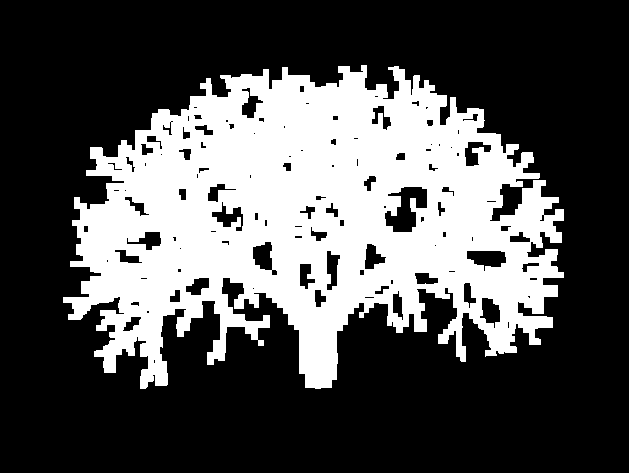

## Utility visualisation functions

In [13]:
def visualize_addition(base, base_with_addition):
    base = (base.copy() > 0).astype(np.uint8)
    addition = (base_with_addition > 0).astype(np.uint8)
    addition[base == 1] = 0
    ColorMapVisualizer(base + addition * 4).visualize()
    
def visualize_lsd(lsd_mask):
    ColorMapVisualizer(lsd_mask.astype(np.uint8)).visualize()
    
def visualize_gradient(lsd_mask):
    ColorMapVisualizer(lsd_mask.astype(np.uint8)).visualize(gradient=True)
    
def visualize_mask_bin(mask):
    VolumeVisualizer((mask > 0).astype(np.uint8), binary=True).visualize()
    
def visualize_mask_non_bin(mask):
    VolumeVisualizer((mask > 0).astype(np.uint8) * 255, binary=False).visualize()
    
def visualize_skeleton(mask, visualize_mask=True, visualize_both_versions=False):
    skeleton = skeletonize_3d((mask > 0).astype(np.uint8))
    if not visualize_mask or visualize_both_versions:
        VolumeVisualizer(skeleton, binary=True).visualize()
    if visualize_mask or visualize_both_versions:
        skeleton = skeleton.astype(np.uint8) * 4
        mask = (mask > 0).astype(np.uint8) * 3
        mask[skeleton != 0] = 0
        ColorMapVisualizer(skeleton + mask).visualize()

def visualize_ultimate(lsd, base_mask):
    visualize_lsd(lsd)
    visualize_mask_non_bin(lsd)
    visualize_addition(base_mask, lsd)
    visualize_skeleton(lsd, visualize_mask=True)

In [14]:
mask = volume

In [15]:
visualize_mask_non_bin(mask)

## Extracting main region 

In [18]:
def get_main_regions(binary_mask, min_size=10_000, connectivity=3):
    labeled = measure.label(binary_mask, connectivity=connectivity)
    region_props = measure.regionprops(labeled)
    
    main_regions = np.zeros(binary_mask.shape)
    bounding_boxes = []
    for props in region_props:
        if props.area >= min_size:
            bounding_boxes.append(props.bbox)
            main_regions = np.logical_or(main_regions, labeled==props.label)
            
    lower_bounds = np.min(bounding_boxes, axis=0)[:3]
    upper_bounds = np.max(bounding_boxes, axis=0)[3:]

    return main_regions[
        lower_bounds[0]:upper_bounds[0],
        lower_bounds[1]:upper_bounds[1],
        lower_bounds[2]:upper_bounds[2],
    ], bounding_boxes

In [36]:
main_region_min_size = {
    'P01': 30_000,
    'P03': 50_000,
    'P07': 300_000,
    'P17': 300_000,
    'MODEL_15': 12_800

}

main_regions, bounding_boxes = get_main_regions(mask, min_size=main_region_min_size.get(TREE_NAME, 12_800))
print('number of main regions:', len(bounding_boxes))
mask_main = main_regions

visualize_mask_bin(mask_main)

number of main regions: 1


# Creating reconstruction using resolution scaling

In [37]:
def f(mask, scale, order=0):
    return zoom(mask, scale, order=order)
    
def verify_mask(mask):
    regions_count = np.max(measure.label(mask, connectivity=3))
    print("one-piece mask" if regions_count == 1 else f"scattered mask, number of regions: {regions_count}")

In [40]:
s_mask_main = mask_main
verify_mask(s_mask_main)

one-piece mask


In [69]:
visualize_mask_non_bin(s_mask_main)

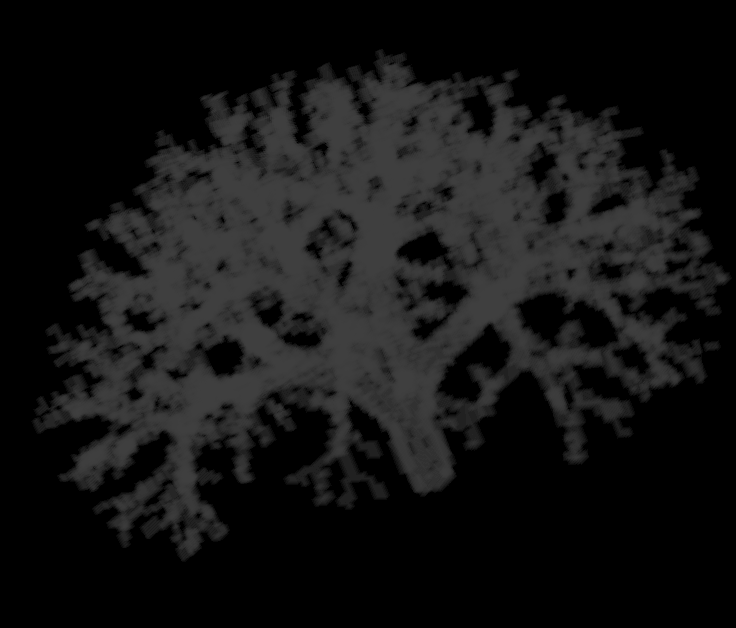

In [42]:
def spherical_kernel(outer_radius, thickness=1, filled=True):    
    outer_sphere = morphology.ball(radius=outer_radius)
    if filled:
        return outer_sphere
    
    thickness = min(thickness, outer_radius)
    
    inner_radius = outer_radius - thickness
    inner_sphere = morphology.ball(radius=inner_radius)
    
    begin = outer_radius - inner_radius
    end = begin + inner_sphere.shape[0]
    outer_sphere[begin:end, begin:end, begin:end] -= inner_sphere
    return outer_sphere

def convolve_with_ball(img, ball_radius, dtype=np.uint16, normalize=True, fft=True):
    kernel = spherical_kernel(ball_radius, filled=True)
    if fft:
        convolved = fftconvolve(img.astype(dtype), kernel.astype(dtype), mode='same')
    else:
        convolved = signal.convolve(img.astype(dtype), kernel.astype(dtype), mode='same')
    
    if not normalize:
        return convolved
    
    return (convolved / kernel.sum()).astype(np.float16)

def calculate_reconstruction(mask, kernel_sizes=[10, 9, 8], fill_threshold=0.5, iters=1, conv_dtype=np.uint16, fft=True):
    kernel_sizes_maps = []
    mask = mask.astype(np.uint8)
    
    for i in range(iters):
        kernel_size_map = np.zeros(mask.shape, dtype=np.uint8)

        for kernel_size in kernel_sizes:
            fill_percentage = convolve_with_ball(mask, kernel_size, dtype=conv_dtype, normalize=True, fft=fft)
            
            above_threshold_fill_indices = fill_percentage > fill_threshold
            kernel_size_map[above_threshold_fill_indices] = kernel_size + 1

            mask[above_threshold_fill_indices] = 1
            
            print(f'Iteration {i + 1} kernel {kernel_size} done')

        kernel_sizes_maps.append(kernel_size_map)
        print(f'Iteration {i + 1} ended successfully')

    return kernel_sizes_maps

In [ ]:
#PSEUDO
def calculate_reconstruction(volume, iterations):
    reconstructed_volume = volume.copy()
    for i in range(iterations):
        for kernel_radius in range(1, 26):
            fill_percentage = convolve_with_ball(volume, kernel_radius)
            above_fill_threshold_mask = fill_percentage > 0.5
            reconstructed_volume[above_fill_threshold_mask] = 1
    return reconstructed_volume

In [43]:
%%time

s_kernel_sizes = {
    'P01': range(0, 14),
    'P02': range(0, 14),
#     'P03': range(0, 13),
#     'P04': range(0, 13),
#     'P05': range(0, 13),
#     'P06': range(0, 13),
    'P07': range(0, 14),
    'P09': range(0, 12),
    'P10': range(0, 12),
#     'P11': range(0, 13),
#     'P12': range(0, 13),
    'P13': range(0, 16),
#     'P14': range(0, 13),
    'P15': range(0, 14),
#     'P16': range(0, 13),
    'P17': range(0, 14),
#     'P18': range(0, 13),
    'P19': range(0, 12),
#     'P20': range(0, 13),
    'P21': range(0, 12),
    'P23': range(0, 14),
#     'P24': range(0, 13),
#     'P25': range(0, 13),
#     'P26': range(0, 13),
#     'P27': range(0, 13)
    'P28': range(0, 14),
}

s_number_of_iterations = {
    'P01': 7,
    'P02': 1,
    'P03': 10,
    'P04': 2,
    'P05': 3,
    'P06': 5,
    'P07': 4,
    'P09': 6,
    'P10': 5,
    'P11': 4, 
    'P12': 3,
    'P13': 3,
    'P14': 2,
    'P15': 3,
    'P16': 5,
    'P17': 10,
    'P18': 4,
    'P19': 2,
    'P20': 1,
    'P21': 3,
    'P23': 5,
    'P24': 2,
    'P25': 6,
    'P26': 6,
    'P27': 1,
    'P28': 1,
    'P30': 1,
    'P31': 3,
    'P32': 3,
    'P33': 3,
}

s_recos = calculate_reconstruction(mask_main, 
                                   kernel_sizes=s_kernel_sizes.get(TREE_NAME, range(0, 13)), 
                                   iters=s_number_of_iterations.get(TREE_NAME, 3))

Iteration 1 kernel 0 done
Iteration 1 kernel 1 done
Iteration 1 kernel 2 done
Iteration 1 kernel 3 done
Iteration 1 kernel 4 done
Iteration 1 kernel 5 done
Iteration 1 kernel 6 done
Iteration 1 kernel 7 done
Iteration 1 kernel 8 done
Iteration 1 kernel 9 done
Iteration 1 kernel 10 done
Iteration 1 kernel 11 done
Iteration 1 kernel 12 done
Iteration 1 ended successfully
Iteration 2 kernel 0 done
Iteration 2 kernel 1 done
Iteration 2 kernel 2 done
Iteration 2 kernel 3 done
Iteration 2 kernel 4 done
Iteration 2 kernel 5 done
Iteration 2 kernel 6 done
Iteration 2 kernel 7 done
Iteration 2 kernel 8 done
Iteration 2 kernel 9 done
Iteration 2 kernel 10 done
Iteration 2 kernel 11 done
Iteration 2 kernel 12 done
Iteration 2 ended successfully
Iteration 3 kernel 0 done
Iteration 3 kernel 1 done
Iteration 3 kernel 2 done
Iteration 3 kernel 3 done
Iteration 3 kernel 4 done
Iteration 3 kernel 5 done
Iteration 3 kernel 6 done
Iteration 3 kernel 7 done
Iteration 3 kernel 8 done
Iteration 3 kernel 9 d

In [44]:
visualize_mask_non_bin(s_recos[-1])

In [46]:
s_reco = s_recos[-1] > 0

In [47]:
np.save('../data/reconstructed/' + TREE_NAME, np.array(s_reco))

# Evaluation

In [48]:
reconstuction = s_reco
original = mask_main

In [49]:
reconstuction.shape

(88, 59, 76)

In [50]:
original.shape

(88, 59, 76)

In [68]:
visualize_addition(original, reconstuction)

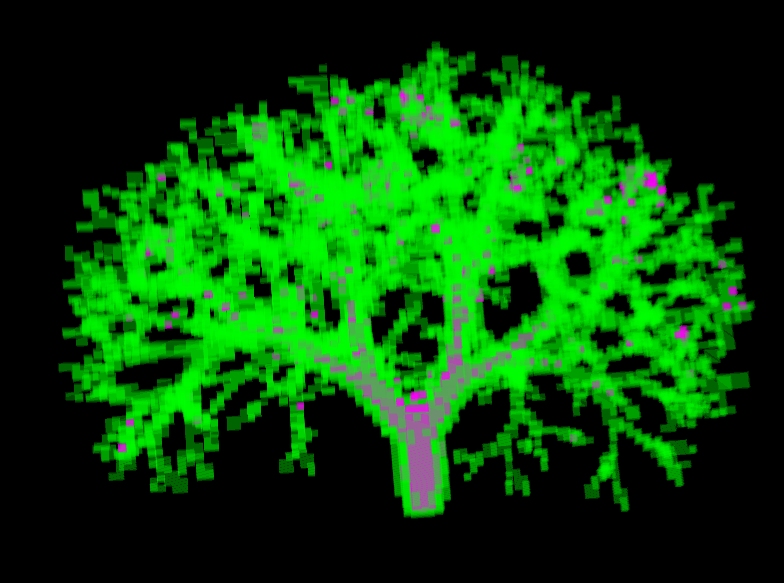

# DICE

In [52]:
def dice_coefficient(img1, img2):
    intersection = np.logical_and(img1, img2)
    return 2. * intersection.sum() / (img1.sum() + img2.sum())

dice_score = dice_coefficient(original, reconstuction)

print("Dice coefficient: ", dice_score)

Dice coefficient:  0.9722876015488573


# Hausdorff distance

In [53]:
from scipy.spatial.distance import directed_hausdorff


original_points_list = np.array(tuple(zip(*np.nonzero(original))))
reconstr_points_list = np.array(tuple(zip(*np.nonzero(reconstuction))))

In [54]:
directed_hausdorff(original_points_list, reconstr_points_list)

(0.0, 2732, 2780)

In [55]:
directed_hausdorff(reconstr_points_list, original_points_list)

(2.0, 6559, 6234)

# Confusion matrix

In [56]:
from sklearn.metrics import confusion_matrix
original_flat = np.ravel(original)
recons_flat = np.ravel(reconstuction)

conf_mat = confusion_matrix(original_flat, recons_flat)
print(conf_mat)

[[381056    730]
 [     0  12806]]


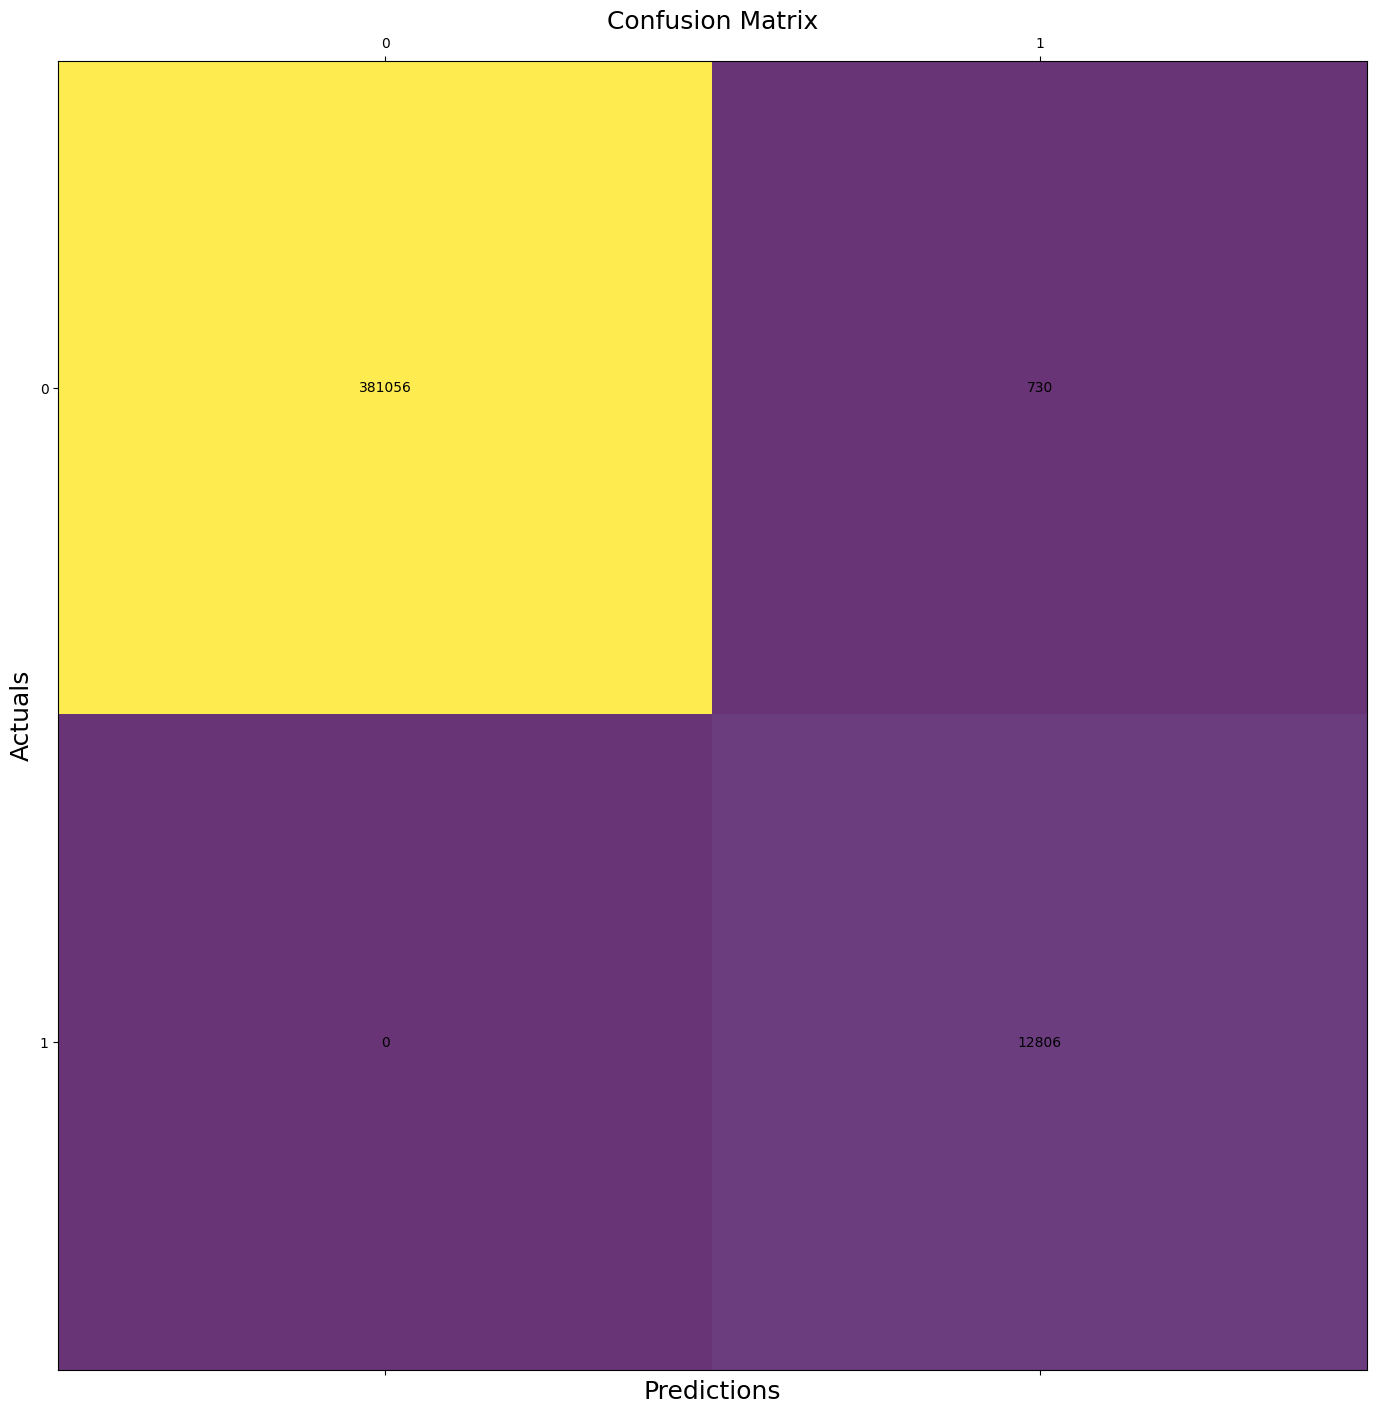

In [67]:
fig, ax = plt.subplots(figsize=(17, 17))
ax.matshow(conf_mat, cmap=plt.cm.viridis, alpha=0.8)
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(x=j, y=i,s=conf_mat[i, j], va='center', ha='center')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()